# Analisis de Mapas III

### Jeff McMahon y Renée Hložek. Traducción por Cristian Vargas 

# Polarización del CMB

En esta sección generalizamos nuestro código para manejar la polarización. Esto significa crear mapas T, E y B siguiendo el mismo procedimiento general que usamos para generar los mapas T (pero con una correlación entre T y E). Luego transformamos estos mapas en mapas Q y U. Estos cálculos se realizan en la aproximación de cielo plano, pero el tratamiento en un cielo curvo es análogo.

Después de simular estos mapas, presentamos los problemas asociados con un cielo cortado y la mezcla de modos E-B asociada. Luego presentamos el estimador pseudo-$C_\ell$ sin-fugas de Kendrick Smith como una de las posibles soluciones a este problema de mezcla.

## Incorporando código anterior

In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

#%cd /Carpeta/donde/estan/los/archivos
%matplotlib inline
import constantes as cs   # modulo de constantes

from cmb_modulos import * # modulo de funciones

También leemos las constantes para el ruido del mapa, la forma del haz y las fuentes puntuales para que podamos usarlas en los ejercicios.

In [2]:
N = cs.N
N_iteraciones = cs.N_iteraciones
c_min = cs.c_min
c_max = cs.c_max
X_ancho = cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_haz_fwhm = cs.tamaño_haz_fwhm
tamaño_pix = cs.tamaño_pix

Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX
Numero_de_Cumulos_SZ  = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ

SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_central

nivel_de_ruido_blanco = cs.nivel_de_ruido_blanco
nivel_de_ruido_atmosferico = 0 #cs.nivel_de_ruido_atmosferico
nivel_de_ruido_1sobref = 0     #cs.nivel_de_ruido_1sobref

## necesitaremos una funcion ventana, así que la creamos acá
ventana = (ventana_coseno(N))

## Leer y graficar los espectros de potencia TT, EE, BB y TE

Con la polarización hay cuatro espectros de potencia cosmológicos con los que trabajar. Por lo que el principal desafio es tener que manejar cuatro veces más elementos.


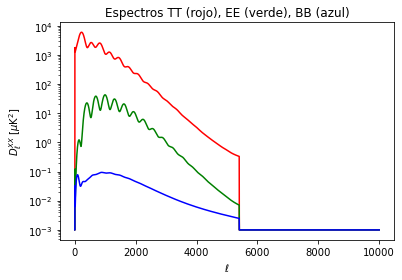

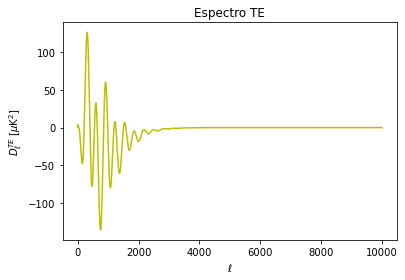

In [3]:
nlargo = 10000 #numero de elementos que tendra el espacio ell
# leer los espectros CMB de entrada
ell,DlTT,DlEE,DlBB,DlTE= np.loadtxt("CMB_fiducial_totalCls.dat", usecols=(0, 1,2,3,4), unpack=True) 

##
ell_largo = np.arange(nlargo) #los elementos van desde 0 hasta 9999
DlTT_largo = np.zeros(nlargo) #donde no está definido queda como 0
DlTT_largo[ell.astype(int)] = DlTT
DlEE_largo = np.zeros(nlargo)
DlEE_largo[ell.astype(int)] = DlEE
DlBB_largo = np.zeros(nlargo)
DlBB_largo[ell.astype(int)] = DlBB
DlTE_largo = np.zeros(nlargo)
DlTE_largo[ell.astype(int)] = DlTE

ell = ell_largo
DlTT = DlTT_largo + 1e-3   ### sumamos 1e-3 para que sea más fácil graficar
DlEE = DlEE_largo + 1e-3
DlBB = DlBB_largo + 1e-3
DlTE = DlTE_largo

Temp_espectro_fuentes_puntuales = DlTT[3000]*(ell/3000.)**2.
Pol_espectro_fuentes_puntuales = DlEE[4500]*(ell/4500.)**2.

DlTT_FP = DlTT + Temp_espectro_fuentes_puntuales   ### estos son usados para calcular la funcion de transferencia
DlEE_FP = DlEE + Pol_espectro_fuentes_puntuales
DlBB_FP = DlBB + Pol_espectro_fuentes_puntuales

plt.semilogy(ell,DlTT,'r')
plt.semilogy(ell,DlEE,'g')
plt.semilogy(ell,DlBB,'b')
plt.title('Espectros TT (rojo), EE (verde), BB (azul)')
plt.ylabel('$D^{XX}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(ell,DlTE,'y')
plt.ylabel('$D^{TE}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('Espectro TE')
plt.show()

Estos espectros probablemente te resulten familiares. Si deseas explorar la dependencia cosmológica de ellos, puedes simularlos usando CAMB en el sitio web LAMBDA de la NASA tal como lo hicimos en la Parte dos de este curso. Un aspecto clave para la simulación y el análisis es que la información en TT, EE y BB está completamente contenida en los mapas T, E y B, respectivamente; mientras que la información de TE está contenida dentro de los mapas de T y E a través de una correlación parcial que surge de cómo se originan las fluctuaciones de T y E en el universo primitivo. Tendremos que incorporar esta correlación cuando simulemos el triplete de los mapas T, E y B


## Simulando mapas T, E y B

Aquí presentamos una función para crear mapas T, Q y U. Para hacer esto, seguimos el mismo procedimiento para crear mapas T, E y B que presentamos en la Parte dos de este curso, con la excepción de introducir una correlación T-E. Luego transformamos a mapas Q y U.

La correlación se introduce (1) generando campos aleatorios gaussianos para la parte T, B y la parte no correlacionada de los mapas E; (2) separando el espectro del modo E en una parte que está correlacionada con T:
$$C_\ell^{EE, correlacionado} = r^2_\ell C_\ell^{EE} $$
donde $$r_\ell = \frac {(C_\ell^{TE})} {\sqrt{C_\ell^{EE}C_\ell^{TT}}},$$ y una parte que tiene representa la amplitud de las fluctuaciones no correlacionadas (elegidas de manera que las fluctuaciones E- correlacionadas y no correlacionadas reproduzcan el espectro EE: $$C_\ell^{no-correlacionado} = (1-r^2_\ell) C_\ell^{EE};$$ y luego generar el mapa E como una suma de realizaciones de estas dos piezas.


La relación entre los mapas E-B y Q-U viene dada por una rotación dependiente de la posición en el espacio de Fourier. Introducimos un ángulo $\psi= \arctan \frac {k_Y} {k_X}$, donde $k_X$ y $k_Y$ son los números de onda en el espacio de Fourier. Con este ángulo la relación entre E-B y Q-U es:
$$\tilde Q = \tilde E \cos 2 \psi - \tilde B \sin 2 \psi$$
$$\tilde U = \tilde E \sin 2 \psi + \tilde B \cos 2 \psi$$

El tilde (~) sobre Q, U, E y B son para recordar que estas cantidades están en el espacio de Fourier.

Como se trata de una rotación simple, la transformada inversa es:
$$\tilde E = \tilde Q \cos 2 \psi + \tilde U \sin 2 \psi$$
$$\tilde B = -\tilde Q \sin 2 \psi + \tilde U \cos 2 \psi$$

promedio del mapa: -2.761679773755077e-15 , media cuadrática (rms) del mapa: 103.22083887110635


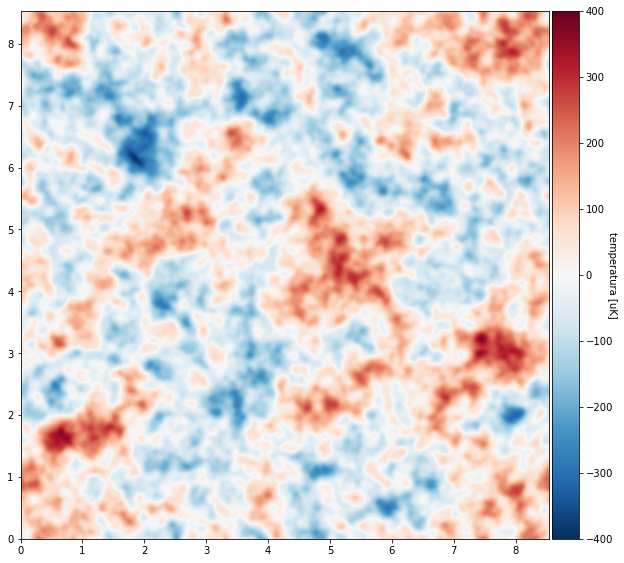

promedio del mapa: -3.122502256758253e-17 , media cuadrática (rms) del mapa: 4.632854735510785


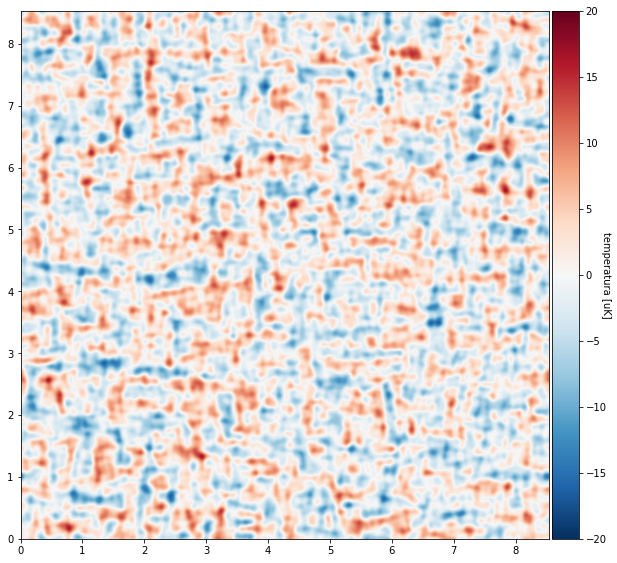

promedio del mapa: -7.37257477290143e-18 , media cuadrática (rms) del mapa: 4.69813125146653


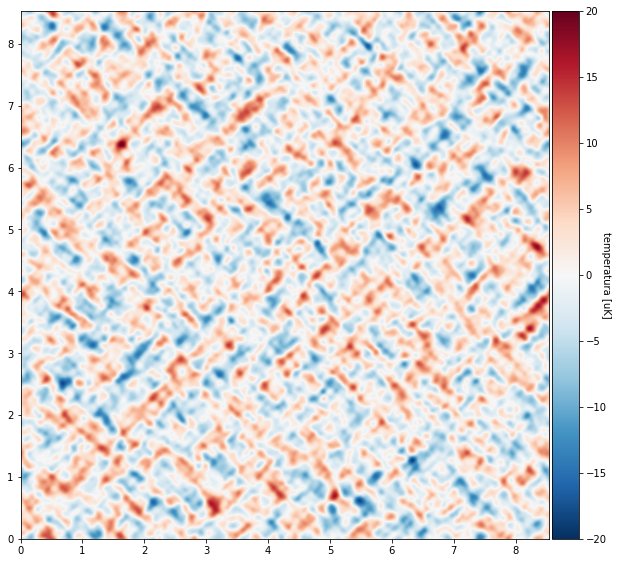

promedio del mapa: -3.469446951953614e-17 , media cuadrática (rms) del mapa: 6.577068901297216


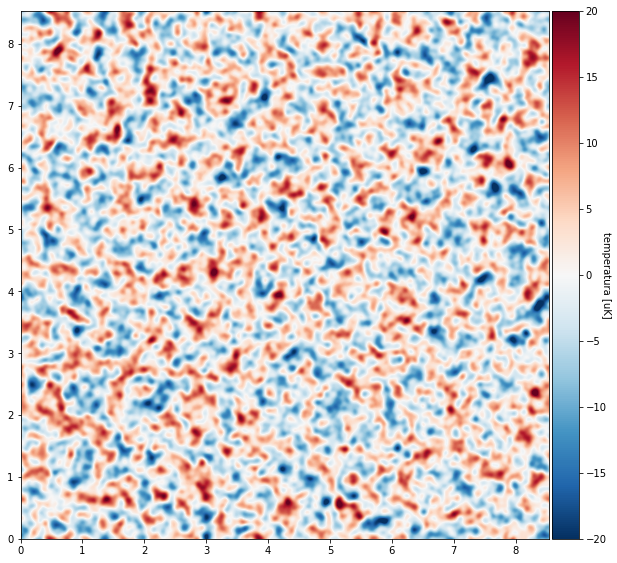

promedio del mapa: -6.071532165918825e-18 , media cuadrática (rms) del mapa: 0.5272048216207477


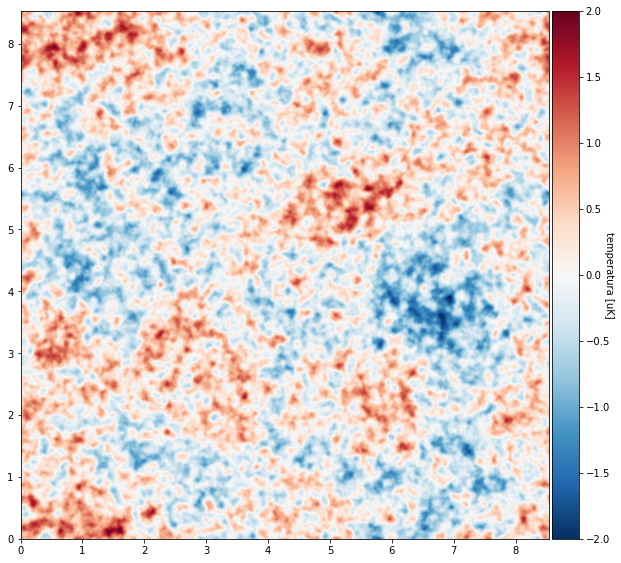

In [4]:
def crear_mapas_CMB(N,tamaño_pix,ell,DlTT,DlEE,DlTE,DlBB):
    "hace una realización de un mapa del cielo CMB simulado"

    # convertir Dl a Cl, usamos np.divide para evitar dividir por cero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = np.divide(DlTT, dell, where=ell>1)
    ClEE = np.divide(DlEE, dell, where=ell>1)
    ClTE = np.divide(DlTE, dell, where=ell>1)
    ClBB = np.divide(DlBB, dell, where=ell>1)
    
    #establecemos los espectros a \ell = 0 y \ell = 1 en cero, 
    #ya que estos no se pueden medir y explotan con la transformación anterior
    
    ClTT[0:2] = 0.
    ClEE[0:2] = 0.
    ClTE[0:2] = 0.
    ClBB[0:2] = 0.

    # separar la parte correlacionada y no-correlacionada del espectro EE
    E_parte_correlacionada = np.divide(ClTE, np.sqrt(ClTT), where=ell>1)
    EE_parte_nocorrelacionada = ClEE - np.divide(ClTE**2., ClTT, where=ell>1)
    
    E_parte_correlacionada[0:2] = 0.
    EE_parte_nocorrelacionada[0:2] = 0.
    
    # hacer un sistema de coordenadas 2d
    unos = np.ones(N)
    indices  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(unos,indices)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## ahora necesitamos este ángulo para manejar la rotación EB <--> QU
    
    # creamos el conjunto de espectros CMB 2d para los mapas T, E y B
    ell_factor_escala = 2. * np.pi / (tamaño_pix/60. * np.pi/180.)
    ell2d = R * ell_factor_escala
    ClTT_expandido = np.zeros(int(ell2d.max())+1)
    ClTT_expandido[0:(ClTT.size)] = ClTT
    ClEE_nocorr_expandido = np.zeros(int(ell2d.max())+1)
    ClEE_nocorr_expandido[0:(EE_parte_nocorrelacionada.size)] = EE_parte_nocorrelacionada
    ClE_corr_expandido = np.zeros(int(ell2d.max())+1)
    ClE_corr_expandido[0:(E_parte_correlacionada.size)] = E_parte_correlacionada
    ClBB_expandido = np.zeros(int(ell2d.max())+1)
    ClBB_expandido[0:(ClBB.size)] = ClBB
    CLTT2d = ClTT_expandido[ell2d.astype(int)]
    ClEE_nocorr_2d = ClEE_nocorr_expandido[ell2d.astype(int)]
    ClE_corr2d = ClE_corr_expandido[ell2d.astype(int)]
    CLBB2d = ClBB_expandido[ell2d.astype(int)]
    
    # ahora hacemos un conjunto de campos aleatorios gaussianos que se convertirán en los mapas CMB
    arreglo_aleatoreo_para_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    arreglo_aleatoreo_para_E = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    arreglo_aleatoreo_para_B = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    
    ## creamos los mapas T, E y B multiplicando los espectros con los campos aleatorios
    TF_2d = np.sqrt(CLTT2d) * arreglo_aleatoreo_para_T
    EF_2d = np.sqrt(ClEE_nocorr_2d) * arreglo_aleatoreo_para_E + ClE_corr2d* arreglo_aleatoreo_para_T
    BF_2d = np.sqrt(CLBB2d) * arreglo_aleatoreo_para_B
    
    ## ahora convertimos E y B en Q y U 
    QF_2d = EF_2d* np.cos(2.*ang) - BF_2d * np.sin(2. *ang)
    UF_2d = EF_2d* np.sin(2.*ang) + BF_2d * np.cos(2. *ang)
    
    ## pasar de espacio de Fourier a espacio real
    CMB_T = np.fft.ifft2(np.fft.fftshift(TF_2d)) /(tamaño_pix /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    CMB_Q = np.fft.ifft2(np.fft.fftshift(QF_2d)) /(tamaño_pix /60.* np.pi/180.)
    CMB_Q = np.real(CMB_Q)
    CMB_U = np.fft.ifft2(np.fft.fftshift(UF_2d)) /(tamaño_pix /60.* np.pi/180.)
    CMB_U = np.real(CMB_U)

    ## código opcional para mostrar mapas E y B
    CMB_E = np.fft.ifft2(np.fft.fftshift(EF_2d)) /(tamaño_pix /60.* np.pi/180.)
    CMB_E = np.real(CMB_E)
    CMB_B = np.fft.ifft2(np.fft.fftshift(BF_2d)) /(tamaño_pix /60.* np.pi/180.)
    CMB_B = np.real(CMB_B)
    
    ## retorna los mapas
    return(CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B)
  ###############################


    
## crear los mapas CMB 
CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B = crear_mapas_CMB(N,tamaño_pix,ell,DlTT,DlEE,DlTE,DlBB)


p = Graficar_Mapa_CMB(CMB_T,c_min,c_max,X_ancho,Y_ancho)
p = Graficar_Mapa_CMB(CMB_Q,c_min/20.,c_max/20.,X_ancho,Y_ancho)
p = Graficar_Mapa_CMB(CMB_U,c_min/20.,c_max/20.,X_ancho,Y_ancho)
p = Graficar_Mapa_CMB(CMB_E,c_min/20.,c_max/20.,X_ancho,Y_ancho)
p = Graficar_Mapa_CMB(CMB_B,c_min/200.,c_max/200.,X_ancho,Y_ancho)

Tener en cuenta el RMS de estos mapas: para T es ~100 $\mu$K, para Q y U ~ 4.5 $\mu$K, E ~ 6.5 $\mu$K y el mapa B tiene rms $< 1 \mu K$. Conocer estos valores es un buen punto de partida para la depuración de simulaciones, la calibración de mapas reales y el seguimiento del impacto del filtrado en los mapas.

<font color='red'>EJERCICIO: </font> Agregue fuentes puntuales y la SZ a estos mapas, luego convolucione con un haz y agregue ruido instrumental. Suponga que las fuentes puntuales tienen una fracción de polarización fija de $3\%$ con ángulos de polarización aleatorios y la SZ está completamente despolarizada. El ruido en los mapas de polarización es $\sqrt 2$ mayor que el ruido en temperatura.


In [5]:
## Aquí va tu código

## Visualizar directamente el campo de polarización

Anteriormente hemos visualizado el campo de polarización utilizando dos métodos diferentes: una descomposición en mapas Q y U de Stokes, y una descomposición en modos E y B. A veces, es útil visualizar el campo de polarización como un campo vectorial de vectores (sin cabeza) que muestran la orientación y la amplitud de la luz polarizada (linealmente).

A continuación, generamos una gráfica como esta usando vectores de longitud $p = \sqrt{Q^2 + U^2}$ y orientación $\psi_p$ dada por $2 \psi_p = \arctan\left( \frac{U}{Q }\right)$. Superponemos este gráfico sobre el mapa del modo E para demostrar que el campo de polarización (que está dominado por los modos E) sigue de cerca este mapa.

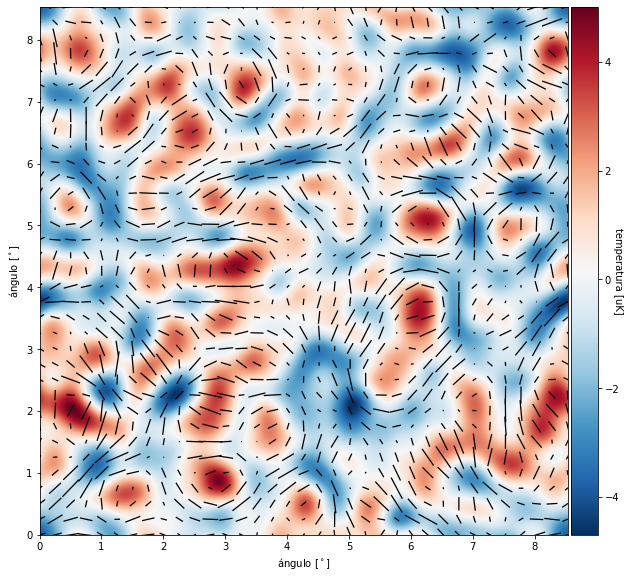

In [6]:
def graficar_vectores(Q, U, X_ancho, Y_, fondo=None):
    '''Visualizar Q, U como vectores sin cabeza'''
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Suavizar mapas para imágenes más agradables
    fwhm_pix = 30
    Q = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,fwhm_pix,Q)
    U = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,fwhm_pix,U)
    if fondo is not None:
        # Si se proporciona, superponemos los vectores sobre el fondo suavizado.
        fondo = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,fwhm_pix,fondo)
    
    Q = Q[::int(fwhm_pix),::int(fwhm_pix)]
    U = U[::int(fwhm_pix),::int(fwhm_pix)]
    
    p_amp = np.sqrt(Q**2 + U**2)
    ang = np.arctan2(U, Q) / 2.
    
    u = p_amp * np.cos(ang)
    v = p_amp * np.sin(ang)

    x = np.linspace(0,X_ancho,u.shape[1])
    y = np.linspace(0,X_ancho,u.shape[0])    
        
    fig, ax = plt.subplots(figsize=(10,10))
    if fondo is not None:
        im = ax.imshow(fondo, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r,
                       extent=([0,X_ancho,0,Y_ancho]))
        divisor = make_axes_locatable(ax)
        cax = divisor.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('temperatura [uK]', rotation=270)
        
    ax.quiver(x, y, u, v, headwidth=1, headlength=0, pivot='mid', units='xy',
              scale_units='xy', scale=2 * p_amp.max(), linewidth=1)
        
    ax.set_ylabel('ángulo $[^\circ]$')
    ax.set_xlabel('ángulo $[^\circ]$')
    
    plt.show(fig)

graficar_vectores(CMB_Q,CMB_U,X_ancho,Y_ancho,fondo=CMB_E)

<font color='red'>EJERCICIO: </font> Genera un campo de polarización dominado por la polarización en modo B y grafica los vectores de polarización en la parte superior del mapa de modo B. ¿Cuál es la diferencia entre el campo de modo E y el campo de modo B?

In [7]:
## Tu código va aquí

<font color='red'>EJERCICIO: </font>  Calcula el espectro de potencia BB utilizando el código y las técnicas de Monte Carlo que exploramos en la cuarta parte. Compara tus resultados con los espectros de entrada. Asegurate de incluir una ventana (es decir, una máscara de píxeles).

<font color='red'>pista: </font> Puedes utilizar la función `QUaEB()` a continuación para convertir mapas Q y U en mapas E y B. Debido a que los datos reales se proporcionarían como mapas Q y U, se debe aplicar una máscara a los mapas Q y U antes de convertirlos a E y B.

promedio del mapa: 0.4052850524609395 , media cuadrática (rms) del mapa: 0.2928208091166568


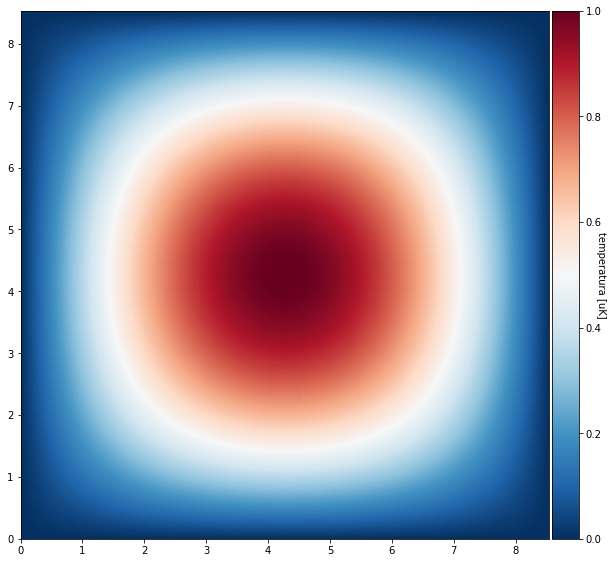

promedio del mapa: 0.04124286413282776 , media cuadrática (rms) del mapa: 3.2490959791089655


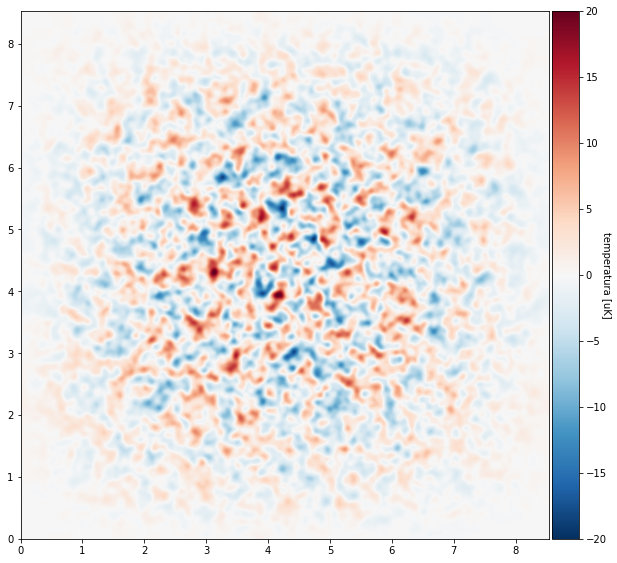

promedio del mapa: 0.01147473649846246 , media cuadrática (rms) del mapa: 0.3924338848837213


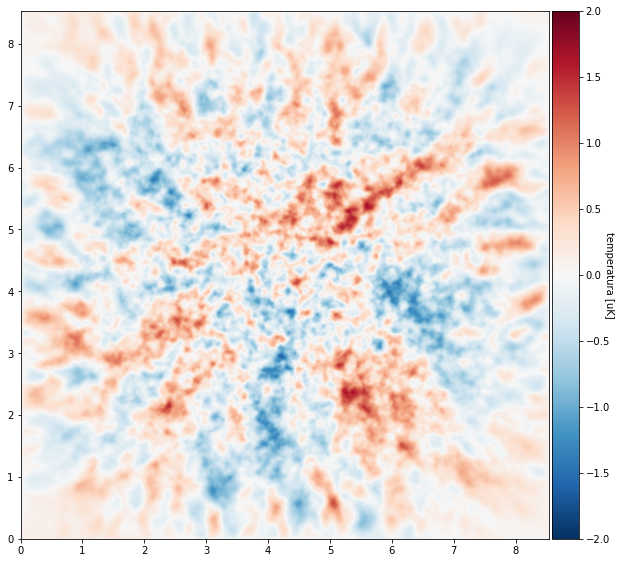

0

In [8]:
def QUaEB(N,tamaño_pix,mapaQ,mapaU,):
    '''Calcula los mapas E y B a partir de los mapas Q y U'''
    
    # Crea un sistema de coordenadas de Fourier en 2D.
    unos = np.ones(N)
    indices  = (np.arange(N) - N/2.) /(N-1.)
    kX = np.outer(unos,indices) / (tamaño_pix/60. * np.pi/180.)
    kY = np.transpose(kX)
    ang = np.arctan2(kY,kX)
  
    # Convertir a dominio de Fourier.
    Qf = np.fft.fftshift(np.fft.fft2(mapaQ))
    Uf = np.fft.fftshift(np.fft.fft2(mapaU))
    
    # Convertir Q, U en E, B en el dominio de Fourier.
    Ef = Qf * np.cos(2.*ang) + Uf * np.sin(2. *ang)
    Bf = - Qf * np.sin(2.*ang) + Uf * np.cos(2. *ang)
    
    # Convertir E, B de Fourier a espacio real.
    mapaE = np.real(np.fft.ifft2(np.fft.fftshift(Ef)))
    mapaB = np.real(np.fft.ifft2(np.fft.fftshift(Bf)))

    return mapaE, mapaB

# Convertir Q y U apodizados en E y B
MapaE, MapaB = QUaEB(N,tamaño_pix,CMB_Q*ventana,CMB_U*ventana)

Graficar_Mapa_CMB(ventana,0,1,X_ancho,Y_ancho)
Graficar_Mapa_CMB(MapaE,-20,20,X_ancho,Y_ancho)
Graficar_Mapa_CMB(MapaB,-2,2,X_ancho,Y_ancho)

Tus notas van aquí

<font color='red'>EJERCICIO: </font> Crea un mapa simulado con $C_\ell^{BB} = 0$. Calcula el espectro de potencia BB de este mapa usando las estimaciones para el sesgo multiplicativo y aditivo calculadas en el ejercicio anterior con $C_\ell^{BB}$ distinto de cero ¿Por qué el resultado no es consistente con $C_\ell^{BB} = 0$

In [9]:
## Tu código va aquí

Tus notas van aquí

<font color='red'>EJERCICIO: </font> Calcula el espectro de potencia de TE adaptando las técnicas de la parte cuatro.

In [10]:
## Tu código va aquí

Tus notas van aquí

## Estimador de modo B sin fugas de Kendrick Smith

Kendrick Smith escribió un <a href=https://arxiv.org/abs/astro-ph/0511629>artículo</a> describiendo su solución al problema de mezcla E-B en cielos cortados. Demostró que la fuga está relacionada con la función de ventana utilizada para apodizar los mapas antes de pasar al espacio de Fourier e identificó correcciones (productos de derivadas de la función ventana y los mapas Q y U en el espacio de Fourier) que se pueden agregar para crear una estimación pura de los modos B.

Implementamos su método aquí para que puedas aplicarlo a tus simulaciones y ver que estima bien el modo B que produjiste anteriormente.


promedio del mapa: -0.8165406323533817 , media cuadrática (rms) del mapa: 52.80140597235683


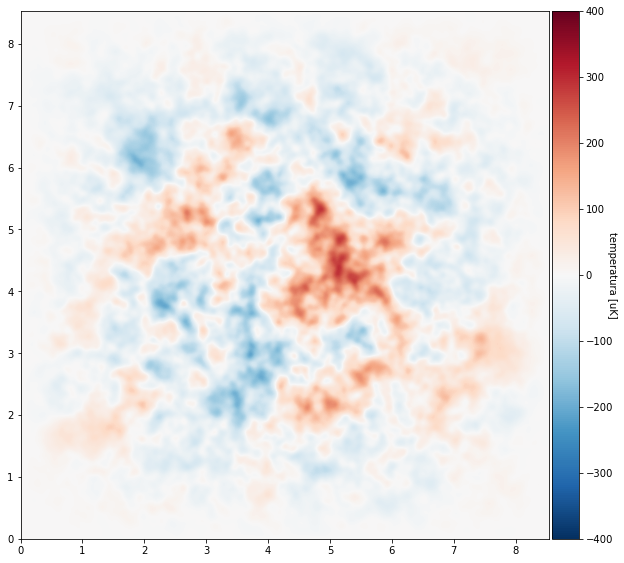

promedio del mapa: 0.041242864132827774 , media cuadrática (rms) del mapa: 3.2490959791089655


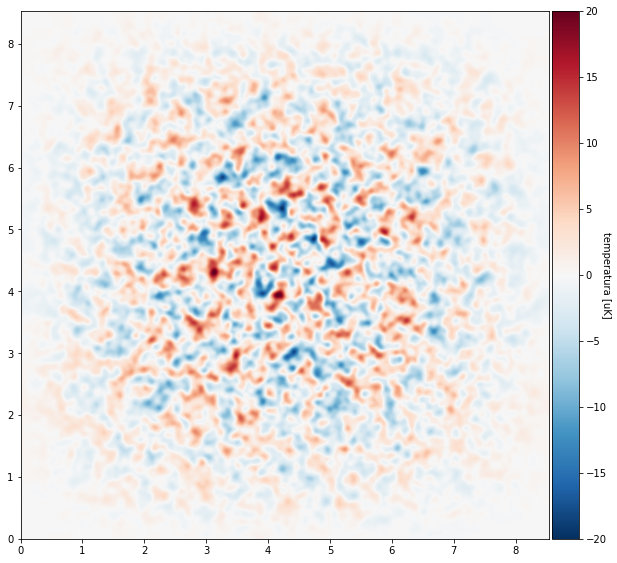

promedio del mapa: 0.0 , media cuadrática (rms) del mapa: 0.29253239059601743


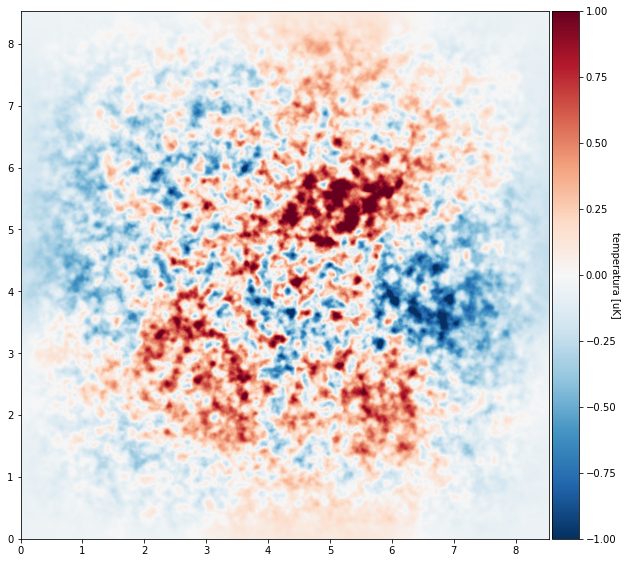

In [11]:
def metodo_kendrick_precomputo_derivada_ventana(ven,tamaño_pix):
    
    delta = tamaño_pix * np.pi /180. /60.
    dven_dx =    ((-1.) * np.roll(ven,-2,axis =1)      +8. * np.roll(ven,-1,axis =1)     - 8. *np.roll(ven,1,axis =1)      +np.roll(ven,2,axis =1) ) / (12. *delta)
    dven_dy =    ((-1.) * np.roll(ven,-2,axis =0)      +8. * np.roll(ven,-1,axis =0)     - 8. *np.roll(ven,1,axis =0)      +np.roll(ven,2,axis =0) ) / (12. *delta)
    d2ven_dx2 =  ((-1.) * np.roll(dven_dx,-2,axis =1)  +8. * np.roll(dven_dx,-1,axis =1) - 8. *np.roll(dven_dx,1,axis =1)  +np.roll(dven_dx,2,axis =1) ) / (12. *delta)
    d2ven_dy2 =  ((-1.) * np.roll(dven_dy,-2,axis =0)  +8. * np.roll(dven_dy,-1,axis =0) - 8. *np.roll(dven_dy,1,axis =0)  +np.roll(dven_dy,2,axis =0) ) / (12. *delta)
    d2ven_dxdy = ((-1.) * np.roll(dven_dy,-2,axis =1)  +8. * np.roll(dven_dy,-1,axis =1) - 8. *np.roll(dven_dy,1,axis =1)  +np.roll(dven_dy,2,axis =1) ) / (12. *delta)
    return(dven_dx,dven_dy,d2ven_dx2,d2ven_dy2,d2ven_dxdy)

def metodo_kendrick_TQU_a_Fourier_TEB(N,tamaño_pix,mapaT,mapaQ,mapaU,ventana,dven_dx,dven_dy,d2ven_dx2,d2ven_dy2,
                                      d2ven_dxdy):
    ### transformadas de Fourier obvias
    fft_TxV = np.fft.fftshift(np.fft.fft2(mapaT * ventana))
    fft_QxV = np.fft.fftshift(np.fft.fft2(mapaQ * ventana))
    fft_UxV = np.fft.fftshift(np.fft.fft2(mapaU * ventana))

    ### transformadas de Fourer no tan obvias que van en el estimador sin fugas
    fft_QxdV_dx = np.fft.fftshift(np.fft.fft2(mapaQ * dven_dx))
    fft_QxdV_dy = np.fft.fftshift(np.fft.fft2(mapaQ * dven_dy))
    fft_UxdV_dx = np.fft.fftshift(np.fft.fft2(mapaU * dven_dx))
    fft_UxdV_dy = np.fft.fftshift(np.fft.fft2(mapaU * dven_dy))
    fft_QU_HOT  = np.fft.fftshift(np.fft.fft2( (2. * mapaQ * d2ven_dxdy) + mapaU * (d2ven_dy2 - d2ven_dx2) ))
    
    ### generar las coordenadas polares necesarias para llevar a cabo la conversión EB-QU
    unos = np.ones(N)
    indices  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(unos,indices)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2. + 1e-9)  ## the small offset regularizes the 1/ell factors below
    ang =  np.arctan2(Y,X)
    ell_factor_escala = 2. * np.pi / (tamaño_pix/60. * np.pi/180.)
    ell2d = R * ell_factor_escala
        
    #p=Graficar_Mapa_CMB(np.real( ang),-np.pi,np.pi,N,N)
    
    
    ### ahora calculamos el estimador
    mapaTf = fft_TxV
    mapaEf = fft_QxV * np.cos(2. * ang) + fft_UxV * np.sin(2. * ang)
    mapaBf = (fft_QxV * (-1. *np.sin(2. * ang)) + fft_UxV * np.cos(2. * ang))  ## this line is the nominal B estimator
    mapaBf = mapaBf - complex(0,2.) / ell2d * (fft_QxdV_dx * np.sin(ang) + fft_QxdV_dy * np.cos(ang))
    mapaBf = mapaBf - complex(0,2.) / ell2d * (fft_UxdV_dy * np.sin(ang) - fft_UxdV_dx * np.cos(ang))
    mapaBf = mapaBf +  ell2d**(-2.) * fft_QU_HOT

    ### retorna los mapas fourier 2d en complejo
    return(mapaTf,mapaEf,mapaBf)

    
    
dven_dx,dven_dy,d2ven_dx2,d2ven_dy2,d2ven_dxdy = metodo_kendrick_precomputo_derivada_ventana(ventana,tamaño_pix)

### graficos de la derivada de las funciones ventana
#p=Graficar_Mapa_CMB(dven_dx,-10,10,X_ancho,Y_ancho)
#p=Graficar_Mapa_CMB(dven_dy,-10,10,X_ancho,Y_ancho)
#p=Graficar_Mapa_CMB(d2ven_dx2,-10,10,X_ancho,Y_ancho)
#p=Graficar_Mapa_CMB(d2ven_dy2,-10,10,X_ancho,Y_ancho)
#p=Graficar_Mapa_CMB(d2ven_dxdy,-10,10,X_ancho,Y_ancho)

mapaTf,mapaEf,mapaBf = metodo_kendrick_TQU_a_Fourier_TEB(N,tamaño_pix,CMB_T,CMB_Q,CMB_U,ventana,dven_dx,dven_dy,
                                                         d2ven_dx2,d2ven_dy2,d2ven_dxdy)

p=Graficar_Mapa_CMB(np.real( (np.fft.ifft2(np.fft.fftshift(mapaTf)))),c_min,c_max,X_ancho,Y_ancho)
p=Graficar_Mapa_CMB(np.real( (np.fft.ifft2(np.fft.fftshift(mapaEf)))),c_min/20.,c_max/20.,X_ancho,Y_ancho)
p=Graficar_Mapa_CMB(np.real( (np.fft.ifft2(np.fft.fftshift(mapaBf))-np.mean(np.fft.ifft2(np.fft.fftshift(mapaBf))))),c_min/400.,c_max/400.,X_ancho,Y_ancho)
               
               


<font color='red'>EJERCICIO: </font> Calcula los espectros de potencia TT, EE, BB, TE, TB y EB usando el código y las técnicas que exploramos en la Parte Cuatro pero con el método Kendrick para modos B. Compara tus resultados con los espectros de entrada y con los espectros que produjo con la separación ingenua E-B. Presta especial atención a la dependencia de escala angular de las diferencias.

In [12]:
## Tu código va aquí

tus comentarios van aquí.

## Nota sobre la corrección de fugas E-B

El estimador de modo B sin fugas en los bloques anteriores elimina los modos B espurios a nivel de mapa. Esto es útil cuando la contribución del modo B debe medirse con precisión desde una pequeña porción del cielo. En los casos en que se pueda tolerar alguna fuga de E a B, la fuga también se puede corregir a nivel del espectro de potencia. Si deseas obtener más información sobre este método, puedes trabajar en el [notebook 8](https://nbviewer.jupyter.org/github/ACTCollaboration/DR4_DR5_Notebooks/blob/bbc7767607c0e51a0a909ffdec617ce6c64d8388/Notebooks/Section_8_power_spectra_part_2.ipynb) de los cuadernillos de DR4_DR5


<font color='red'>EJERCICIO AVANZADO: </font> Toma la función `lens_map` del cuadernillo de lentes (parte 10) y visualiza los mapas Q y U de un campo de polarización que no tiene contribución de modo B. Grafica el espectro de potencia en modo B resultante y comparalo con el espectro de potencia en modo B de CAMB.